In [2]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import inv

In [3]:
# Initialisation 
n = 20
d = 15

l = 10 # lambda (regularization parameter)
Q = 0.5*np.identity(n)
p = -np.random.random(n)
X = np.random.random((n, d))
A = np.vstack((X.T,-X.T))
b = l * np.ones(2*d)
eps = 1e-5
v_o = np.zeros(n)
t = b.shape[0]

In [4]:
def fo(Q,p,A,b,t,v_o): 
    '''
    Q : n * n (nonegative)
    p : n * 1 
    A : 2d * n
    b : 2d * 1 
    t : 1 * 1 
    v_o : n * 1 
    
    '''
    return(np.dot(v_o,np.dot(Q,v_o)) + np.dot(p.T,v_o))   

In [5]:
def ft(Q,p,A,b,t,v_o):
    '''
    output : objective function t f_o + phi
    
    Q : n * n (nonegative)
    p : n * 1 
    A : 2d * n
    b : 2d * 1 
    t : 1 * 1 
    v_o : n * 1 
    '''  
    return(t*(np.dot(v_o.T, np.dot(Q, v_o)) + np.dot(p.T, v_o)) - sum([np.log(b[i]-np.dot(A[i], v_o)) for i in range(b.shape[0])]))

In [6]:
def grad_ft(Q,p,A,b,t,v):
    '''
    output : gradient of ft in v
    
    '''
    return(t*(2*np.dot(Q,v) + p) + sum([A[i].T /((-np.dot(A[i],v) + b[i])) for i in range(2*d)]))

In [7]:
def hess(Q,p,A,b,t,v): 
    '''
    output : hessian of ft in v
    
    '''
    hess_phi = 0 
    for i in range(2*d):
        hess_phi = hess_phi + np.dot(A[i,:],A[i,:].T)/(np.dot(A[i,:],v) - b[i])**2
    
    res = 2*t*Q + sum([np.outer(A[i,np.newaxis].T,A[i,np.newaxis].T)/((b[i]-np.dot(A[i],v))**2) for i in range (b.shape[0])])
    
    return(res)

In [12]:
def backtracking(v,dv,Q,p,A,b,t,alpha = 0.1 ,beta = 0.7):
    '''
    output : stepsize
    
    v : n * 1 
    dv : n * 1
    alpha : 1 * 1 in (0,0.5)
    beta : 1 * 1  in (0,1)
    
    Q : n * n (nonegative)
    p : n * 1 
    A : 2n * n
    b : 2n * 1 
    t : 1 * 1 
    '''
    t_bt = 1 
    
    while ( ft(Q,p,A,b,t,v + t_bt*dv) > ft(Q,p,A,b,t,v) + 
           alpha*t_bt*np.dot(grad_ft(Q,p,A,b,t,v),dv)) :
        t_bt = beta*t_bt
    
    return t_bt

In [14]:
def centering_step(Q,p,A,b,t,v_o,eps,nmax=1000):
    '''
    Q : n * n (nonegative)
    p : n * 1 
    A : 2n * n
    b : 2n * 1 
    t : 1 * 1 
    v_o : n * 1 (starting point)
    eps : 1 * 1
    '''

    v = v_o
    v_seq = [v_o]
    ne = 1
    l_nwt = np.dot(grad_ft(Q,p,A,b,t,v),np.dot(inv(hess(Q,p,A,b,t,v)),grad_ft(Q,p,A,b,t,v).T))
    
     
    while (l_nwt > 2*eps)&(ne<nmax):

        dv = -np.dot(inv(hess(Q,p,A,b,t,v)),grad_ft(Q,p,A,b,t,v))
        
        l_nwt = np.dot(grad_ft(Q,p,A,b,t,v).T,np.dot(inv(hess(Q,p,A,b,t,v)),grad_ft(Q,p,A,b,t,v)))
        
        t_bt = backtracking(v,dv,Q,p,A,b,t,alpha = 0.1 ,beta = 0.7)
        
        v = v + t_bt*dv
        
        v_seq.append(v)
    
        ne = ne + 1
    
    return(v_seq[ne-1],ne)  

In [10]:
def barr_method(Q,p,A,b,v_o,eps,mu,nmax=1000):
    '''
    Q : n * n (nonegative)
    p : n * 1 
    A : 2n * n
    b : 2n * 1 
    t : 1 * 1 
    v_o : n * 1 (starting point)
    eps : 1 * 1
    
    '''
    m = b.shape[0]
    t = 1
    neb = 0
    vseq = [v_o]
    f_seq =[fo(Q,p,A,b,t,v_o)]
    
    while (m/t > eps):
        vtemp, ne = centering_step(Q,p,A,b,t,v_o,eps)
        vseq.append(vtemp)
        t = mu*t 
        neb += 1
        f_seq.append(fo(Q,p,A,b,t,vtemp))

        
    return(vseq,f_seq,neb)

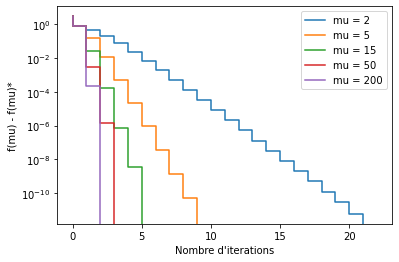

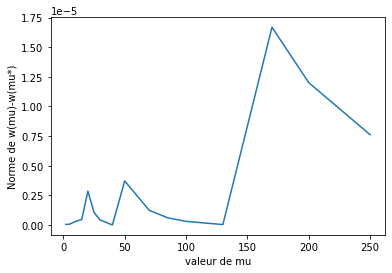

In [15]:
#Plot 
mu_list_bis = [2, 5, 10, 15, 20, 25, 30, 40, 50, 70, 85, 100, 130, 170, 200, 250]
mu_list = [2,5,15,50,150,200,300]
f_star_list =[]
w_star_list =[]

for mu in mu_list_bis :
    vseq, fseq, nb_iter = barr_method(Q,p,A,b,v_o,eps,mu)
    f_star = fseq[-1]
    f_star_list.append(f_star)
    w_star = np.linalg.lstsq(X,vseq[-1]+p,rcond=None)[0]
    w_star_list.append(w_star)
    if mu in mu_list :
        plt.step([i for i in range(nb_iter+1)],fseq - f_star,label='mu = '+str(mu))

plt.legend()
plt.ylabel("f(mu) - f(mu)*")
plt.xlabel("Nombre d'iterations")
plt.semilogy()
plt.show()

#Plot de w en fonction de mu 
mu_min = np.argmin(f_star_list)
plt.figure()

w_error = [np.linalg.norm (w -w_star_list[mu_min]) for w in w_star_list]
plt.plot(mu_list_bis,w_error)
plt.ylabel("Norme de w(mu)-w(mu*)")
plt.xlabel("valeur de mu")
plt.show()
